# Quadratic-Exponential Scheme

In [224]:
def rGauss(u1,u2):
    #u1 = np.random.normal()
    #u2 = np.random.normal()
    z1 = np.sqrt(-2*np.log(u1))*np.cos(2*np.pi*u2)
    z2 = np.sqrt(-2*np.log(u1))*np.sin(2*np.pi*u2)
    return z1,z2

In [1]:
import numpy as np

def Heston_QE(M, N, r, kappa, theta, epsilon, rho, S0, V0):
    # M: number of timesteps
    # N: number of paths
    
    phi_c = 1.5
    C1 = 0.5 
    C2 = 0.5
    
    S = np.zeros((M,N))
    dt = 1/252
    v = np.zeros((M,N))
    
    for j in range(N):
        S[0,j] = S0
        V = V0
        v[0,j] = V0
        
        for i in range(M-1):
            
            m = theta + (V-theta) * np.exp(-kappa*dt)
            s_squared = V * epsilon**2 * np.exp(-kappa*dt) * (1-np.exp(-kappa*dt))/kappa + \
                        theta * epsilon**2 * (1-np.exp(-kappa*dt))**2/(2*kappa)
            phi = s_squared / m**2
            
            
            #u1 = np.random.uniform()
            #u2 = np.random.uniform()
            #u3 = np.random.uniform()
            #u4 = np.random.uniform()
            U = np.random.uniform() #np.random.uniform(size=1)
            #z1, z2 = rGauss(u1,u2)
            ZV = np.random.normal()
            
            if phi <= phi_c:
                b = np.sqrt(2/phi - 1 + (np.sqrt(2/phi)) * np.sqrt(2/phi - 1))
                a_2 = m / (1 + b**2)
                V_delta = a_2 * (b + ZV)**2
            
            else:
                p = (phi - 1) / (phi + 1)
                beta = 2 / (m*(phi + 1))
                
                if U >= 0 and U <= p:
                    V_delta = 0
                else:
                    V_delta = np.log((1-p)/(1-U)) / beta
                    
            K0 = -rho*kappa*theta*dt / epsilon
            K1 = C1*dt*(kappa*rho/epsilon - 0.5) - rho/epsilon
            K2 = C1*dt*(kappa*rho/epsilon - 0.5) + rho/epsilon
            K3 = C1*dt*(1 - rho**2)
            K4 = C2*dt*(1 - rho**2)
            
            S[i+1,j] = S[i,j] * np.exp(r*dt + K0 + K1*V + K2*V_delta + \
                                       np.sqrt(K3*V + K4*V_delta)*np.random.normal())
            v[i+1,j] = V_delta
    
    return S, v

In [2]:
import numpy as np

def Heston_QE_anti(M, N, r, kappa, theta, epsilon, rho, S0, V0):
    # M: number of timesteps
    # N: number of paths
    
    phi_c = 1.5
    C1 = 0.5 
    C2 = 0.5
    
    S = np.zeros((M,N))
    dt = 1/252
    
    for j in range(N):
        S[0,j] = S0
        V = V0
        
        for i in range(M-1):
            
            m = theta + (V-theta) * np.exp(-kappa*dt)
            s_squared = V * epsilon**2 * np.exp(-kappa*dt) * (1-np.exp(-kappa*dt))/kappa + \
                        theta * epsilon**2 * (1-np.exp(-kappa*dt))**2/(2*kappa)
            phi = s_squared / m**2
            ZV = -np.random.normal(size=1)
            U = np.random.uniform(size=1)
            
            if phi <= phi_c:
                b = np.sqrt(2/phi - 1 + (np.sqrt(2/phi)) * np.sqrt(2/phi - 1))
                a_2 = m / (1 + b**2)
                V_delta = a_2 * (b + ZV)**2
            
            else:
                p = (phi - 1) / (phi + 1)
                beta = 2 / (m*(phi + 1))
                
                if U <= p:
                    V_delta = 0
                else:
                    V_delta = np.log((1-p)/(1-U)) / beta
                    
            K0 = -rho*kappa*theta*dt / epsilon
            K1 = C1*dt*(kappa*rho/epsilon - 0.5) - rho/epsilon
            K2 = C1*dt*(kappa*rho/epsilon - 0.5) + rho/epsilon
            K3 = C1*dt*(1 - rho**2)
            K4 = C2*dt*(1 - rho**2)
            
            S[i+1,j] = S[i,j] * np.exp(r*dt + K0 + K1*V + K2*V_delta + \
                                       np.sqrt(K3*V + K4*V_delta)*(-np.random.normal(size=(1))))
            V = V_delta
    
    return S

In [2]:
def EMartingale(S,r,q):
    M = S.shape[0]
    N = S.shape[1]
    eS = np.zeros((M,N))
    zS = np.zeros(N)
    dt = 1/252
    
    eS[0,:] = S[0,:]
    for i in range(1,M):
        for j in range(N):
            zS[j] = eS[i-1,j] * S[i,j] / S[i-1,j]
        Z0 = np.exp(-(r-q)*i*dt) * np.mean(zS)
        for j in range(N):
            eS[i,j] = eS[0,j] * zS[j] / Z0
    return eS

In [5]:
def multioptions_price(S,r,tau,K):
    """has been modified to just get the u for boundary"""
    M = S.shape[0]
    N = S.shape[1]
    u_values = np.zeros(M)
    
    for i in range(M):
        summ = 0
        for x in (S[i,:] - K[i]):
            summ += np.maximum(x,0)
        
        u_values[i] = np.exp(-r*tau[i])*summ/N
        
    ## alternatively
    #for i in range(M):
    #    S1 = S[i,:] - K[i]
    #    S1[np.where(S1<0)] = 0
    #    V_values[i] = np.exp(-r*tau[i])*np.mean(S1)
    
    return u_values

In [2]:
def multioptions_price(S,r,tau,K):
    M = S.shape[0]
    N = S.shape[1]
    P = K.shape[0]
    u_values = np.zeros((M,P))
    
    for j in range(P):
        for i in range(M):
            
            
            summ = np.sum(np.maximum((S[i,:] - K[j]),0))
            
            u_values[i,j] = np.exp(-r*tau[i])*summ/N
            
        ## alternatively
        #for i in range(M):
        #    S1 = S[i,:] - K[i]
        #    S1[np.where(S1<0)] = 0
        #    V_values[i] = np.exp(-r*tau[i])*np.mean(S1)
    
    return u_values

## Generate data: Black-Scholes_nn (Heston as input data)

In [256]:
np.random.seed(0)
S,V = Heston_QE(1*252,10000,0.04, 12,0.04,0.5,-0.97,0.67,0.025)
#M, N, r, kappa, theta, epsilon, rho, S0, V0
S1 = EMartingale(S,0.04,0)

M = S1.shape[0]


x = 0.67
tau = np.linspace(0,6,M)
K = np.linspace(0.15,0.85,)
x = np.log(s/K
u = multioptions_price(S1,0.04,tau,K)
u_tilda = u/K

data = {'t': tau, 'x':x, 'usol':u_tilda, 'K':K }

import pickle
filename = 'Heston_Simulation_data_3'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

## Generate data: Heston (predict parameters)

In [22]:
np.random.seed(0)
S, V = Heston_QE(1*252,10000,0.04, 12,0.04,0.5,-0.97,0.67,0.025)
#M, N, r, kappa, theta, epsilon, rho, S0, V0
S1 = EMartingale(S,0.04,0)

M = S1.shape[0]
S0 = 0.67    
tau = np.linspace(0,1,M)
K = np.linspace(0.55,0.85,100) # changed from 0.15 to 0.35
x = np.log(0.67/K)
u = multioptions_price(S1,0.04,tau,K)
u_tilda = u/K
K,_ = np.meshgrid(K,tau)

data = {'t': tau, 'x':x, 'usol':u_tilda, 'K':K}

import pickle
filename = 'Heston_Simulation_data_3'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

In [9]:
import scipy

np.random.seed(0)
S, V = Heston_QE(1*20,10000,0.02, 12,0.02,0.5,-0.97,2000,0.16)
#M, N, r, kappa, theta, epsilon, rho, S0, V0
S1 = EMartingale(S,0.02,0)

M = S1.shape[0]
S0 = 2000
x = scipy.linspace(0.5,2.,50)
K = S0/x
tau = np.linspace(0.1,1,M)
#K = np.linspace(35,140,50) # changed from 0.15 to 0.35
#x = np.log(70/K)

u = multioptions_price(S1,0.02,tau,K)
u_tilda = u/K
K,_ = np.meshgrid(K,tau)

data = {'t': tau, 'x':x, 'usol':u_tilda, 'K':K}

import pickle
filename = 'Heston_Simulation_data_3'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

# Increase Number of Simulation Path

In [167]:
import scipy

np.random.seed(0)
S, V = Heston_QE(1*252,1000000,0.02, 12,0.02,0.5,-0.97,2000,0.16)
#M, N, r, kappa, theta, epsilon, rho, S0, V0
S1 = EMartingale(S,0.02,0)

M = S1.shape[0]
S0 = 2000
x = scipy.linspace(0.5,2.,50)
K = S0/x
tau = np.linspace(0.1,1,M)
#K = np.linspace(35,140,50) # changed from 0.15 to 0.35
#x = np.log(70/K)

u = multioptions_price(S1,0.02,tau,K)
u_tilda = u/K
K,_ = np.meshgrid(K,tau)

t = tau.flatten()[:,None]
x = (x.flatten()[:,None])
K = K.flatten()[:,None]
Exact = u_tilda

X, T = np.meshgrid(x,t)

######shuffle######
Data = np.hstack((X.flatten()[:,None], T.flatten()[:,None], Exact.flatten()[:,None], K))
#Data = np.vstack((Data,Data.copy(),Data.copy()))
#np.random.shuffle(Data)
X_star_1 = Data[:,0:2]
u_star = Data[:,2][:,None]
K = Data[:,-1][:,None]

## ***
## filter 20 t-points desired

In [140]:
ls = []
for i in range(252):
    if i%13 == 0:
        ls.append(i)

In [141]:
len(ls)
idx = np.array(ls)

In [142]:
x = scipy.linspace(0.5,2.,50)
tau = np.linspace(0.1,1,252)
tau = tau[idx,]
u_tilda = Exact[idx,:]
K = S0/x
K,_ = np.meshgrid(K,tau)

In [143]:
data = {'t': tau, 'x':x, 'usol':u_tilda, 'K':K}

import pickle
filename = 'Heston_Simulation_data_1'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

In [81]:
infile =open('Heston_Simulation_data_1','rb')
data = pickle.load(infile)
infile.close()

In [144]:
X, T = np.meshgrid(x.flatten()[:,None],tau.flatten()[:,None])

In [145]:
u_min = np.maximum((X.flatten()[:,None]-np.exp(-0.02*T.flatten()[:,None])),0)

In [146]:
for y in np.hstack([u_tilda.flatten()[:,None],u_min, X.flatten()[:,None],T.flatten()[:,None]]):
    print(y)

[0.  0.  0.5 0.1]
[0.         0.         0.53061224 0.1       ]
[0.         0.         0.56122449 0.1       ]
[0.         0.         0.59183673 0.1       ]
[0.         0.         0.62244898 0.1       ]
[0.         0.         0.65306122 0.1       ]
[0.         0.         0.68367347 0.1       ]
[0.         0.         0.71428571 0.1       ]
[0.         0.         0.74489796 0.1       ]
[0.        0.        0.7755102 0.1      ]
[0.         0.         0.80612245 0.1       ]
[0.         0.         0.83673469 0.1       ]
[0.         0.         0.86734694 0.1       ]
[0.         0.         0.89795918 0.1       ]
[0.         0.         0.92857143 0.1       ]
[0.         0.         0.95918367 0.1       ]
[0.         0.         0.98979592 0.1       ]
[0.02036739 0.02240616 1.02040816 0.1       ]
[0.05091847 0.05301841 1.05102041 0.1       ]
[0.08146955 0.08363065 1.08163265 0.1       ]
[0.11202063 0.1142429  1.1122449  0.1       ]
[0.14257171 0.14485514 1.14285714 0.1       ]
[0.1731228  0.175467

In [116]:
XX = np.hstack([u_tilda.flatten()[:,None],u_min, X.flatten()[:,None],T.flatten()[:,None]])
XX[np.argwhere(u_tilda.flatten()[:,None]<u_min)][0:100,:]

NameError: name 'u_tilda' is not defined

In [164]:
tau

array([0.1       , 0.14661355, 0.19322709, 0.23984064, 0.28645418,
       0.33306773, 0.37968127, 0.42629482, 0.47290837, 0.51952191,
       0.56613546, 0.612749  , 0.65936255, 0.7059761 , 0.75258964,
       0.79920319, 0.84581673, 0.89243028, 0.93904382, 0.98565737])


## filter 20 t-points desired
## ***

In [168]:
u_min = np.maximum((X_star_1[:,0:1]-np.exp(-0.02*X_star_1[:,1:2])),0)

In [169]:
for x in np.hstack([u_star,u_min, X_star_1]):
    print(x)

[0.  0.  0.5 0.1]
[0.         0.         0.53061224 0.1       ]
[0.         0.         0.56122449 0.1       ]
[0.         0.         0.59183673 0.1       ]
[0.         0.         0.62244898 0.1       ]
[0.         0.         0.65306122 0.1       ]
[0.         0.         0.68367347 0.1       ]
[0.         0.         0.71428571 0.1       ]
[0.         0.         0.74489796 0.1       ]
[0.        0.        0.7755102 0.1      ]
[0.         0.         0.80612245 0.1       ]
[0.         0.         0.83673469 0.1       ]
[0.         0.         0.86734694 0.1       ]
[0.         0.         0.89795918 0.1       ]
[0.         0.         0.92857143 0.1       ]
[0.         0.         0.95918367 0.1       ]
[0.         0.         0.98979592 0.1       ]
[0.02036739 0.02240616 1.02040816 0.1       ]
[0.05091847 0.05301841 1.05102041 0.1       ]
[0.08146955 0.08363065 1.08163265 0.1       ]
[0.11202063 0.1142429  1.1122449  0.1       ]
[0.14257171 0.14485514 1.14285714 0.1       ]
[0.1731228  0.175467

[0.66370887 0.66676514 1.66326531 0.1752988 ]
[0.69426477 0.69737739 1.69387755 0.1752988 ]
[0.72482071 0.72798963 1.7244898  0.1752988 ]
[0.75537669 0.75860188 1.75510204 0.1752988 ]
[0.78593266 0.78921412 1.78571429 0.1752988 ]
[0.81648865 0.81982637 1.81632653 0.1752988 ]
[0.84704464 0.85043861 1.84693878 0.1752988 ]
[0.87760063 0.88105086 1.87755102 0.1752988 ]
[0.90815663 0.9116631  1.90816327 0.1752988 ]
[0.93871262 0.94227535 1.93877551 0.1752988 ]
[0.96926861 0.97288759 1.96938776 0.1752988 ]
[0.9998246  1.00349984 2.         0.1752988 ]
[0.         0.         0.5        0.17888446]
[0.         0.         0.53061224 0.17888446]
[0.         0.         0.56122449 0.17888446]
[6.83849805e-08 0.00000000e+00 5.91836735e-01 1.78884462e-01]
[3.54066144e-07 0.00000000e+00 6.22448980e-01 1.78884462e-01]
[2.45585737e-06 0.00000000e+00 6.53061224e-01 1.78884462e-01]
[1.28449221e-05 0.00000000e+00 6.83673469e-01 1.78884462e-01]
[5.34957306e-05 0.00000000e+00 7.14285714e-01 1.78884462e-01]


[0.66543493 0.66819336 1.66326531 0.24701195]
[0.69598077 0.69880561 1.69387755 0.24701195]
[0.72653154 0.72941785 1.7244898  0.24701195]
[0.7570856  0.7600301  1.75510204 0.24701195]
[0.78764181 0.79064234 1.78571429 0.24701195]
[0.81819966 0.82125459 1.81632653 0.24701195]
[0.84875852 0.85186683 1.84693878 0.24701195]
[0.8793181  0.88247908 1.87755102 0.24701195]
[0.90987805 0.91309132 1.90816327 0.24701195]
[0.94043819 0.94370357 1.93877551 0.24701195]
[0.97099854 0.97431581 1.96938776 0.24701195]
[1.00155898 1.00492806 2.         0.24701195]
[5.72966176e-08 0.00000000e+00 5.00000000e-01 2.50597610e-01]
[5.42307575e-07 0.00000000e+00 5.30612245e-01 2.50597610e-01]
[4.04213892e-06 0.00000000e+00 5.61224490e-01 2.50597610e-01]
[1.70952283e-05 0.00000000e+00 5.91836735e-01 2.50597610e-01]
[5.82172831e-05 0.00000000e+00 6.22448980e-01 2.50597610e-01]
[1.64329618e-04 0.00000000e+00 6.53061224e-01 2.50597610e-01]
[4.09600161e-04 0.00000000e+00 6.83673469e-01 2.50597610e-01]
[0.00092291 0.

[0.63696331 0.63900729 1.63265306 0.3187251 ]
[0.66741436 0.66961953 1.66326531 0.3187251 ]
[0.69789323 0.70023178 1.69387755 0.3187251 ]
[0.72839348 0.73084402 1.7244898  0.3187251 ]
[0.7589097  0.76145627 1.75510204 0.3187251 ]
[0.7894383  0.79206851 1.78571429 0.3187251 ]
[0.81997647 0.82268076 1.81632653 0.3187251 ]
[0.85052161 0.853293   1.84693878 0.3187251 ]
[0.88107199 0.88390525 1.87755102 0.3187251 ]
[0.91162638 0.91451749 1.90816327 0.3187251 ]
[0.94218342 0.94512974 1.93877551 0.3187251 ]
[0.97274248 0.97574198 1.96938776 0.3187251 ]
[1.00330303 1.00635423 2.         0.3187251 ]
[6.37361368e-06 0.00000000e+00 5.00000000e-01 3.22310757e-01]
[2.18240293e-05 0.00000000e+00 5.30612245e-01 3.22310757e-01]
[6.48547712e-05 0.00000000e+00 5.61224490e-01 3.22310757e-01]
[1.72459315e-04 0.00000000e+00 5.91836735e-01 3.22310757e-01]
[4.03874492e-04 0.00000000e+00 6.22448980e-01 3.22310757e-01]
[0.00085203 0.         0.65306122 0.32231076]
[0.00165392 0.         0.68367347 0.32231076]


[0.63956082 0.64043142 1.63265306 0.39043825]
[0.66985061 0.67104366 1.66326531 0.39043825]
[0.70019578 0.70165591 1.69387755 0.39043825]
[0.73058624 0.73226815 1.7244898  0.39043825]
[0.76101333 0.7628804  1.75510204 0.39043825]
[0.79146918 0.79349264 1.78571429 0.39043825]
[0.8219479  0.82410489 1.81632653 0.39043825]
[0.85244515 0.85471713 1.84693878 0.39043825]
[0.88295728 0.88532938 1.87755102 0.39043825]
[0.91348156 0.91594162 1.90816327 0.39043825]
[0.94401541 0.94655387 1.93877551 0.39043825]
[0.97455668 0.97716611 1.96938776 0.39043825]
[1.00510413 1.00777836 2.         0.39043825]
[4.71035502e-05 0.00000000e+00 5.00000000e-01 3.94023904e-01]
[1.24320847e-04 0.00000000e+00 5.30612245e-01 3.94023904e-01]
[2.88566188e-04 0.00000000e+00 5.61224490e-01 3.94023904e-01]
[0.0006101  0.         0.59183673 0.3940239 ]
[0.00119444 0.         0.62244898 0.3940239 ]
[0.00217046 0.         0.65306122 0.3940239 ]
[0.00369402 0.         0.68367347 0.3940239 ]
[0.0059519  0.         0.7142857

[0.61269151 0.61124126 1.60204082 0.46215139]
[0.64268076 0.6418535  1.63265306 0.46215139]
[0.6727695  0.67246575 1.66326531 0.46215139]
[0.70294024 0.70307799 1.69387755 0.46215139]
[0.73317994 0.73369024 1.7244898  0.46215139]
[0.76347628 0.76430248 1.75510204 0.46215139]
[0.79382063 0.79491473 1.78571429 0.46215139]
[0.82420452 0.82552697 1.81632653 0.46215139]
[0.85462075 0.85613922 1.84693878 0.46215139]
[0.88506521 0.88675146 1.87755102 0.46215139]
[0.91553213 0.91736371 1.90816327 0.46215139]
[0.94601794 0.94797595 1.93877551 0.46215139]
[0.9765198  0.9785882  1.96938776 0.46215139]
[1.00703461 1.00920044 2.         0.46215139]
[1.64502327e-04 0.00000000e+00 5.00000000e-01 4.65737052e-01]
[3.66727212e-04 0.00000000e+00 5.30612245e-01 4.65737052e-01]
[0.00074173 0.         0.56122449 0.46573705]
[0.00138242 0.         0.59183673 0.46573705]
[0.00241342 0.         0.62244898 0.46573705]
[0.00397527 0.         0.65306122 0.46573705]
[0.00623219 0.         0.68367347 0.46573705]
[0

[0.61652179 0.61266131 1.60204082 0.53386454]
[0.64626892 0.64327355 1.63265306 0.53386454]
[0.67613578 0.6738858  1.66326531 0.53386454]
[0.70610794 0.70449804 1.69387755 0.53386454]
[0.73617004 0.73511029 1.7244898  0.53386454]
[0.76630847 0.76572253 1.75510204 0.53386454]
[0.79651342 0.79633478 1.78571429 0.53386454]
[0.82677446 0.82694702 1.81632653 0.53386454]
[0.85708377 0.85755927 1.84693878 0.53386454]
[0.88743368 0.88817151 1.87755102 0.53386454]
[0.91781815 0.91878376 1.90816327 0.53386454]
[0.94823259 0.949396   1.93877551 0.53386454]
[0.97867159 0.98000825 1.96938776 0.53386454]
[1.00913168 1.01062049 2.         0.53386454]
[3.89948632e-04 0.00000000e+00 5.00000000e-01 5.37450199e-01]
[0.00077796 0.         0.53061224 0.5374502 ]
[0.00142468 0.         0.56122449 0.5374502 ]
[0.00244747 0.         0.59183673 0.5374502 ]
[0.00397273 0.         0.62244898 0.5374502 ]
[0.00615623 0.         0.65306122 0.5374502 ]
[0.009153   0.         0.68367347 0.5374502 ]
[0.01310834 0.    

[0.59129459 0.58346708 1.57142857 0.60557769]
[0.62064286 0.61407932 1.60204082 0.60557769]
[0.65015348 0.64469157 1.63265306 0.60557769]
[0.67980661 0.67530381 1.66326531 0.60557769]
[0.70958359 0.70591606 1.69387755 0.60557769]
[0.73946637 0.7365283  1.7244898  0.60557769]
[0.76944194 0.76714054 1.75510204 0.60557769]
[0.79949899 0.79775279 1.78571429 0.60557769]
[0.8296274  0.82836503 1.81632653 0.60557769]
[0.85981729 0.85897728 1.84693878 0.60557769]
[0.89005961 0.88958952 1.87755102 0.60557769]
[0.92034617 0.92020177 1.90816327 0.60557769]
[0.95067229 0.95081401 1.93877551 0.60557769]
[0.98103333 0.98142626 1.96938776 0.60557769]
[1.01142507 1.0120385  2.         0.60557769]
[0.00074476 0.         0.5        0.60916335]
[0.00135587 0.         0.53061224 0.60916335]
[0.00232075 0.         0.56122449 0.60916335]
[0.00375919 0.         0.59183673 0.60916335]
[0.00581191 0.         0.62244898 0.60916335]
[0.00860893 0.         0.65306122 0.60916335]
[0.01228036 0.         0.68367347 

[0.59599071 0.58488306 1.57142857 0.67729084]
[0.62509208 0.6154953  1.60204082 0.67729084]
[0.65436824 0.64610755 1.63265306 0.67729084]
[0.68380095 0.67671979 1.66326531 0.67729084]
[0.71337214 0.70733204 1.69387755 0.67729084]
[0.74306577 0.73794428 1.7244898  0.67729084]
[0.77286729 0.76855653 1.75510204 0.67729084]
[0.80276503 0.79916877 1.78571429 0.67729084]
[0.83274631 0.82978102 1.81632653 0.67729084]
[0.86280261 0.86039326 1.84693878 0.67729084]
[0.89292411 0.89100551 1.87755102 0.67729084]
[0.92310201 0.92161775 1.90816327 0.67729084]
[0.95332978 0.95223    1.93877551 0.67729084]
[0.98360144 0.98284224 1.96938776 0.67729084]
[1.01391195 1.01345449 2.         0.67729084]
[0.00124808 0.         0.5        0.68087649]
[0.00213766 0.         0.53061224 0.68087649]
[0.00346556 0.         0.56122449 0.68087649]
[0.00535856 0.         0.59183673 0.68087649]
[0.00794255 0.         0.62244898 0.68087649]
[0.01134222 0.         0.65306122 0.68087649]
[0.01567682 0.         0.68367347 

[0.57215644 0.55568476 1.54081633 0.74900398]
[0.60082626 0.58629701 1.57142857 0.74900398]
[0.62970616 0.61690925 1.60204082 0.74900398]
[0.65877205 0.6475215  1.63265306 0.74900398]
[0.68800531 0.67813374 1.66326531 0.74900398]
[0.71738621 0.70874599 1.69387755 0.74900398]
[0.74690105 0.73935823 1.7244898  0.74900398]
[0.77653327 0.76997048 1.75510204 0.74900398]
[0.8062719  0.80058272 1.78571429 0.74900398]
[0.8361058  0.83119497 1.81632653 0.74900398]
[0.86602417 0.86180721 1.84693878 0.74900398]
[0.89601773 0.89241946 1.87755102 0.74900398]
[0.92607824 0.9230317  1.90816327 0.74900398]
[0.9561982  0.95364395 1.93877551 0.74900398]
[0.98637115 0.98425619 1.96938776 0.74900398]
[1.01659156 1.01486844 2.         0.74900398]
[0.00185979 0.         0.5        0.75258964]
[0.00305289 0.         0.53061224 0.75258964]
[0.00475631 0.         0.56122449 0.75258964]
[0.00708676 0.         0.59183673 0.75258964]
[0.01016755 0.         0.62244898 0.75258964]
[0.01412366 0.         0.65306122 

[0.57736095 0.55709669 1.54081633 0.82071713]
[0.60581229 0.58770893 1.57142857 0.82071713]
[0.63448293 0.61832118 1.60204082 0.82071713]
[0.66334796 0.64893342 1.63265306 0.82071713]
[0.69238716 0.67954567 1.66326531 0.82071713]
[0.72158434 0.71015791 1.69387755 0.82071713]
[0.75092524 0.74077016 1.7244898  0.82071713]
[0.78039492 0.7713824  1.75510204 0.82071713]
[0.80997965 0.80199465 1.78571429 0.82071713]
[0.839669   0.83260689 1.81632653 0.82071713]
[0.86945317 0.86321914 1.84693878 0.82071713]
[0.89932151 0.89383138 1.87755102 0.82071713]
[0.92926586 0.92444363 1.90816327 0.82071713]
[0.95927738 0.95505587 1.93877551 0.82071713]
[0.98934929 0.98566812 1.96938776 0.82071713]
[1.01947632 1.01628036 2.         0.82071713]
[0.0025942  0.         0.5        0.82430279]
[0.00409439 0.         0.53061224 0.82430279]
[0.00617976 0.         0.56122449 0.82430279]
[0.00896483 0.         0.59183673 0.82430279]
[0.01255331 0.         0.62244898 0.82430279]
[0.0170534  0.         0.65306122 

[0.55459158 0.52789434 1.51020408 0.89243028]
[0.58259827 0.55850659 1.54081633 0.89243028]
[0.61085348 0.58911883 1.57142857 0.89243028]
[0.63933299 0.61973108 1.60204082 0.89243028]
[0.66801356 0.65034332 1.63265306 0.89243028]
[0.69688012 0.68095557 1.66326531 0.89243028]
[0.72591113 0.71156781 1.69387755 0.89243028]
[0.75509156 0.74218006 1.7244898  0.89243028]
[0.78440845 0.7727923  1.75510204 0.89243028]
[0.81384991 0.80340455 1.78571429 0.89243028]
[0.84340399 0.83401679 1.81632653 0.89243028]
[0.87305803 0.86462904 1.84693878 0.89243028]
[0.90280226 0.89524128 1.87755102 0.89243028]
[0.93262707 0.92585353 1.90816327 0.89243028]
[0.96252577 0.95646577 1.93877551 0.89243028]
[0.99249148 0.98707802 1.96938776 0.89243028]
[1.02251888 1.01769026 2.         0.89243028]
[0.00345502 0.         0.5        0.89601594]
[0.00528478 0.         0.53061224 0.89601594]
[0.0077489  0.         0.56122449 0.89601594]
[0.01095713 0.         0.59183673 0.89601594]
[0.01501377 0.         0.62244898 

[0.56004029 0.52930222 1.51020408 0.96414343]
[0.58787329 0.55991447 1.54081633 0.96414343]
[0.61595055 0.59052671 1.57142857 0.96414343]
[0.64425294 0.62113896 1.60204082 0.96414343]
[0.67276244 0.6517512  1.63265306 0.96414343]
[0.7014613  0.68236345 1.66326531 0.96414343]
[0.73033293 0.71297569 1.69387755 0.96414343]
[0.75936243 0.74358794 1.7244898  0.96414343]
[0.78853345 0.77420018 1.75510204 0.96414343]
[0.81783452 0.80481243 1.78571429 0.96414343]
[0.84725343 0.83542467 1.81632653 0.96414343]
[0.87677824 0.86603692 1.84693878 0.96414343]
[0.90639985 0.89664916 1.87755102 0.96414343]
[0.93610973 0.92726141 1.90816327 0.96414343]
[0.96590102 0.95787365 1.93877551 0.96414343]
[0.99576593 0.9884859  1.96938776 0.96414343]
[1.02569848 1.01909814 2.         0.96414343]
[0.00441104 0.         0.5        0.96772908]
[0.00657217 0.         0.53061224 0.96772908]
[0.0094306  0.         0.56122449 0.96772908]
[0.01307519 0.         0.59183673 0.96772908]
[0.01759725 0.         0.62244898 

## 20 t-points

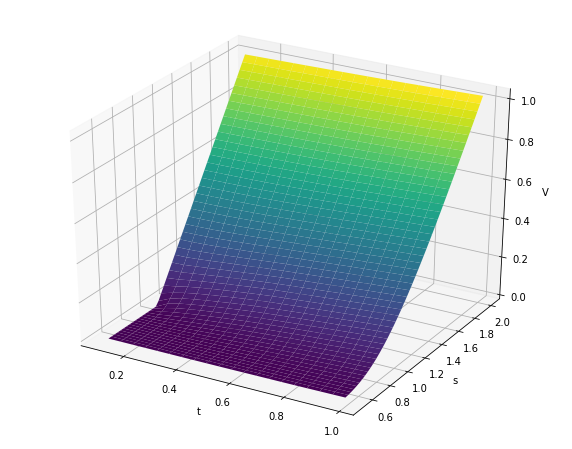

In [147]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
%matplotlib inline
fig = plt.figure(figsize=(10,8))

#ax = Axes3D(fig) #<-- Note the difference from your original code...

#T, S = np.meshgrid(tau, x)

#fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(t, s, V, 50, cmap='jet')
ax.plot_surface(T,X,u_tilda, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('t')
ax.set_ylabel('s')
ax.set_zlabel('V')
plt.show()

## 252 t-points

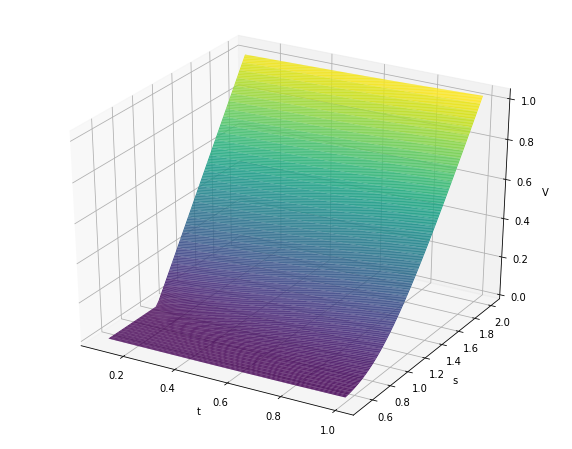

In [118]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
%matplotlib inline
fig = plt.figure(figsize=(10,8))

#ax = Axes3D(fig) #<-- Note the difference from your original code...

#T, S = np.meshgrid(tau, x)

#fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(t, s, V, 50, cmap='jet')
ax.plot_surface(T,X,u_tilda, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('t')
ax.set_ylabel('s')
ax.set_zlabel('V')
plt.show()

## plot u_min

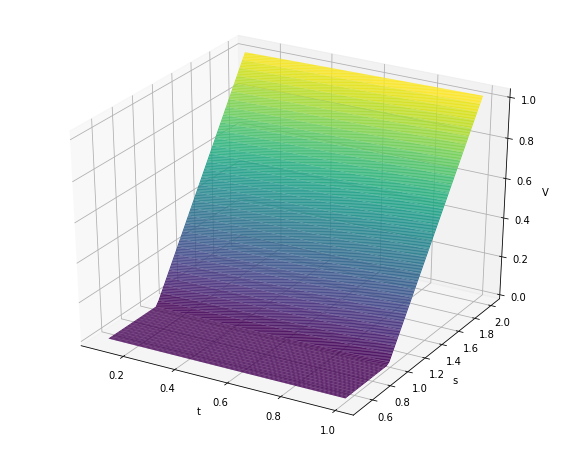

In [123]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
%matplotlib inline
fig = plt.figure(figsize=(10,8))

#ax = Axes3D(fig) #<-- Note the difference from your original code...

#T, S = np.meshgrid(tau, x)

#fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(t, s, V, 50, cmap='jet')
ax.plot_surface(T,X,u_min.reshape(u_tilda.shape), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('t')
ax.set_ylabel('s')
ax.set_zlabel('V')
plt.show()

In [11]:
import pickle
infile = open('Heston_Simulation_data_3','rb')
data = pickle.load(infile)
infile.close() 
import numpy as np
X, T = np.meshgrid(data['x'],data['t'])
print(data['usol'].shape)
print(K.shape)

(20, 50)
(20, 50)


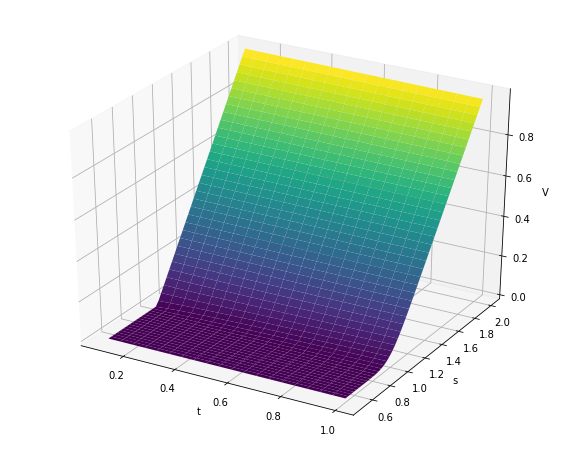

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
%matplotlib inline
fig = plt.figure(figsize=(10,8))

#ax = Axes3D(fig) #<-- Note the difference from your original code...

T, S = np.meshgrid(tau, x)

#fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(t, s, V, 50, cmap='jet')
ax.plot_surface(T,S,u_tilda.T, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('t')
ax.set_ylabel('s')
ax.set_zlabel('V')
plt.show()

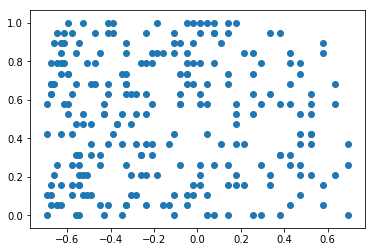

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
s = S.flatten()
t = T.flatten()
#plt.figure()
#plt.scatter(X_star_1[:,0][0:250],X_star_1[:,1][0:250])
#plt.figure()
#plt.scatter(X_star_1[:,0][250:500],X_star_1[:,1][250:500])
#plt.figure()
#plt.scatter(X_star_1[:,0][500:750],X_star_1[:,1][500:750])
#plt.figure()
np.random.shuffle(s)
np.random.shuffle(t)
plt.scatter(s[250:500],t[250:500])


In [13]:
u_tilda.shape

(252, 100)

## Case 1

In [278]:
#np.random.seed(1)
#S,V = Heston_QE(6*252,10000,0.04, 12,0.04,0.5,-0.97,0.67,0.025)
#S1 = EMartingale(S,0.04,0)
summ = 0
M = 6*252
N = 10000
for x in (S1[M-1,:] - 0.35):
    summ += np.maximum(x,0)
np.exp(-0.04*6)*summ/N


0.3951188208537212

In [243]:
np.exp(-0.04*6)*0.50640

0.39834834884410264

In [227]:
summ = 0
for x in (S1[M-1,:] - 0.85):
    summ += np.maximum(x,0)
summ/N

0.16327488014124325

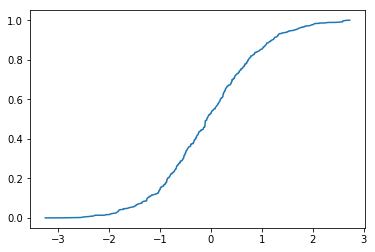

In [33]:
import scipy.stats
import matplotlib.pyplot as plt

plt.plot(np.sort(np.random.normal(size=1000)),scipy.stats.norm.cdf(np.sort(np.random.normal(size=1000))))
plt.show()

In [215]:
np.random.uniform()

0.6674947950734162

### Antithetic

In [5]:
np.random.seed(0)
S = Heston_QE(6*252,10000,0.04, 12,0.04,0.5,-0.97,0.67,0.025)
S_anti = Heston_QE_anti(6*252,10000,0.04, 12,0.04,0.5,-0.97,0.67,0.025)
S1 = EMartingale(S,0.04,0)
S1_anti = EMartingale(S,0.04,0)
summ = 0
M = 6*252
N = 10000
for x in (S1[M-1,:] - 0.35):
    summ += np.maximum(x,0)
for x in (S1_anti[M-1,:] - 0.35):
    summ += np.maximum(x,0)
summ/(2*N)

0.5058691872395099

In [627]:
summ = 0
for x in (S1[M-1,:] - 0.75):
    summ += np.maximum(x,0)
for x in (S1_anti[M-1,:] - 0.75):
    summ += np.maximum(x,0)
summ/(2*N)

0.03176915560029598

## Case 2

In [615]:
np.random.seed(0)
S = Heston_QE(252,10000,0.04, 8,0.04,0.75,-0.97,0.67,0.025)
S1 = EMartingale(S,0.04,0,1/252)
summ = 0
M = 252
N = 10000
for x in (S1[M-1,:] - 0.35):
    summ += np.maximum(x,0)
summ/N

0.34754398158794475

In [617]:
summ = 0
for x in (S1[M-1,:] - 0.85):
    summ += np.maximum(x,0)
summ/N

0.0041257416315952635

In [572]:
np.random.seed(0)
S = Heston_QE(252,10000,0.04, 12,0.04,0.5,-0.97,0.67,0.025)
summ = 0
M = 252
N = 10000
for x in (S[M-1,:] - 0.35):
    summ += np.maximum(x,0)
summ/N

0.3350731769542342

In [577]:
summ = 0
for x in (S[M-1,:] - 0.85):
    summ += np.maximum(x,0)
summ/N

0.0

# Euler Scheme

In [309]:
def Heston_Euler(M, N, r, kappa, theta, epsilon, rho, S0, V0):
    
    S = np.zeros((M,N))
    S[0,:] = S0
    V = V0 
    dt = 1/252

    for i in range(M-1):
        
        Z1 = np.random.normal(size=(N))
        Z2 = np.random.normal(size=(N))
        Zv = Z1 
        Zs = rho*Z1 + np.sqrt(1 - rho**2)*Z2
        
        S[i+1,:] = S[i,:]*np.exp((r-V/2)*dt + np.sqrt(V*dt)*Zs)
        V_delta = V + kappa*(theta - V)*dt + epsilon*np.sqrt(V*dt)*Zv
        if V_delta < 0:
            V_delta = 0
        V = V_delta

    return S
    

In [316]:
np.random.seed(0)
S = Heston_Milstein(6*252,10000,0.04, 12,0.04,0.5,-0.97,0.67,0.025)
#S = EMartingale(S,0.04,0)
summ = 0
M = 6*252
N = 10000
for x in (S[M-1,:] - 0.35):
    summ += np.maximum(x,0)
summ/N*np.exp(-0.04*6)

0.4018754904552749

In [315]:
np.random.seed(0)
S = Heston_Euler(6*252,1000,0.04, 12,0.04,0.5,-0.97,0.67,0.025)
#S = EMartingale(S,0.04,0)
summ = 0
M = 6*252
N = 1000
for x in (S[M-1,:] - 0.35):
    summ += np.maximum(x,0)
summ/N*np.exp(-0.04*6)

KeyboardInterrupt: 

In [301]:
heston_analytic(kp=12, vp=0.04, eta=0.5, rho1=-0.97, v=0.025, T=6, X=np.log(0.67*np.exp(0.04*6)/0.45))*0.45*np.exp(-0.04*6)

0.39747437553259723

In [281]:
np.random.seed(0)
S = Heston_Euler(100,1000,0.05, 2,0.09,0.2,-0.3,100,0.09)
#S = EMartingale(S,0.05,0)
summ = 0
M = 100
N = 1000
for x in (S[M-1,:] - 100):
    summ += np.maximum(x,0)
summ/N*np.exp(-0.05*1)

14.894419653392763

In [302]:
heston_analytic(kp=2, vp=0.09, eta=0.2, rho1=-0.3, v=0.09, T=1, X=np.log(100*np.exp(0.05*1)/100))*100*np.exp(-0.05*1)

14.174422477969124

In [297]:
from scipy import *
from scipy.integrate import quad
'''Reference: https://github.com/teramonagi/py_HestonModel2/blob/master/heston.py'''


#public
def call_price(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    p1 = __p1(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K)
    p2 = __p2(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K)
    return (s0 * p1 - K * exp(-r * T) * p2)

#private
def __p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 , K, status):
    integrand = lambda phi: (exp(-1j * phi * log(K)) * 
    __f(phi, kappa, theta, sigma, rho, v0, r, T, s0, status) / (1j * phi)).real    
    return (0.5 + (1 / pi) * quad(integrand, 0, 1000)[0])
def __p1(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    return __p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 1)
def __p2(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    return __p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 2)
def __f(phi, kappa, theta, sigma, rho, v0, r, T, s0, status):
        
    if status == 1:
        u = 0.5
        b = kappa - rho * sigma
    else:
        u = -0.5
        b = kappa
    
    a = kappa * theta
    x = log(s0)
    d = sqrt((rho * sigma * phi * 1j - b)**2 - sigma**2 * (2 * u * phi * 1j - phi**2))
    g = (b - rho * sigma * phi * 1j + d) / (b - rho * sigma * phi * 1j - d)
    C = r * phi * 1j * T + (a / sigma**2)*((b - rho * sigma * phi * 1j + d) * T - 2 * log((1 - g * exp(d * T))/(1 - g)))
    D = (b - rho * sigma * phi * 1j + d) / sigma**2 * ((1 - exp(d * T)) / (1 - g * exp(d * T)))
    return exp(C + D * v0 + 1j * phi * x)

call_price(2,0.09,0.2,-0.3,0.09,0.05,1,100,100)
call_price(6,0.04,0.75,-0.97,0.025,0.04,3.5,0.67,0.35)

C:\Users\keeyh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  app.launch_new_instance()


0.396755637810189

# Milstein Scheme

In [313]:
def Heston_Milstein(M, N, r, kappa, theta, epsilon, rho, S0, V0):
    
    S = np.zeros((M,N))
    S[0,:] = S0
    V = V0
    dt = 1/252
    
    for i in range(M-1):
        
        Z1 = np.random.normal(size=(N))
        Z2 = np.random.normal(size=(N))
        Zv = Z1 
        Zs = rho*Z1 + np.sqrt(1 - rho**2)*Z2
        
        S[i+1,:] = S[i,:] + r*S[i,:]*dt + np.sqrt(V*dt)*S[i,:]*Zs + 0.25*S[i,:]**2*dt*(Zs**2 - 1)

        V_delta = V + kappa*(theta - V)*dt + epsilon*np.sqrt(V*dt)*Zv + 0.25*epsilon**2*dt*(Zv**2 - 1)
        
        V_delta[np.where(V_delta < 0)] = 0
        #if np.all(V_delta < 0):
        #    V_delta = np.zeros(N)
        V = V_delta

    return S
    

In [233]:
def Heston_Milstein(M, N, r, kappa, theta, epsilon, rho, S0, V0):
    
    S = np.zeros((M,N))

    dt = 1/252
    for j in range(N):
        S[0,j] = S0
        V = V0
        for i in range(M-1):
            
            Z1 = np.random.normal(size=(1))
            Z2 = np.random.normal(size=(1))
            Zv = Z1 
            Zs = rho*Z1 + np.sqrt(1 - rho**2)*Z2
            
            S[i+1,j] = S[i,j] + r*S[i,j]*dt + np.sqrt(V*dt)*S[i,j]*Zs + 0.25*S[i,j]**2*dt*(Zs**2 - 1)
    
            V_delta = V + kappa*(theta - V)*dt + epsilon*np.sqrt(V*dt)*Zv + 0.25*epsilon**2*dt*(Zv**2 - 1)
            if V_delta < 0:
                V_delta = 0
            V = V_delta

    return S
    

In [481]:
np.random.seed(4)
S = Heston_Milstein(500,1000,0,1,0.16,2,-0.8,1,0.16)
summ = 0
M = 500
N = 1000
for x in (S[M-1,:] - 2):
    summ += np.maximum(x,0)
summ/N

0.2101536496499937

In [34]:
#np.random.seed(0)
S = Heston_Milstein(6*252,10000,0.04, 12,0.04,0.5,-0.97,0.67,0.025)
S = EMartingale(S,0.04,0)
summ = 0
M = 6*252
N = 10000
for x in (S[M-1,:] - 0.35):
    summ += np.maximum(x,0)
summ/N

0.5065021277615444

In [56]:
summ = 0
for x in (S[M-252,:] - 0.85):
    summ += np.maximum(x,0)
summ/N

0.13115645967301867

In [120]:
def BS_Euler(M, N, r, sigma, S0):
    
    S = np.zeros((M,N))
    S[0,:] = S0 
    dt = 0.9/499

    for i in range(M-1):
        
        Z1 = np.random.normal(size=(N))
        S[i+1,:] = S[i,:]*np.exp((r-sigma**2/2)*dt + sigma*np.sqrt(dt)*Z1)

    return S

In [121]:
import scipy
import numpy as np
x = scipy.linspace(0.5,2.,1000) # x = S/K
S0 = 2000
tau = np.linspace(0.1,1,500)

np.random.seed(0)
S = BS_Euler(500,10000,0.02, 0.4,2000)
#S = GARCH_Milstein(2501,10000,0.02, 2,0.055,0.6,-0.7,2000,0.055)
K = S0/x
u = multioptions_price(S,0.02,tau,K)
u_tilda = u/K

In [122]:
K = S0/x
K,_=np.meshgrid(K,tau)

In [123]:
X,T = np.meshgrid(x,tau)
X = X.flatten()[:,None]
T = T.flatten()[:,None]
u_min = np.maximum((X-np.exp(-0.02*T)),0)
u_tilda = u_tilda.flatten()[:,None]

In [124]:
u_tilda = np.maximum(u_tilda,u_min)
u_tilda = u_tilda.reshape(500,1000)

In [125]:
ls = []
for i in range(499):
    if i%25 == 0:
        ls.append(i)
idx1 = np.array(ls)
idx1.shape

(20,)

In [126]:
ls = []
for i in range(998):
    if i%20 == 0:
        ls.append(i)
idx2 = np.array(ls)
idx2.shape

(50,)

In [127]:
# domain

# first, remove the initial and boundary
u_tilda_dom = u_tilda[:,1::] # retain all except b1
u_tilda_dom = u_tilda_dom[:,0:-1] # retain all except b2
u_tilda_dom = u_tilda_dom[1::,:] # retain all except ini

K_dom = K[:,1::]
K_dom = K_dom[:,0:-1]
K_dom = K_dom[1::,:] 

x_dom = x[1:-1]
tau_dom = tau[1::]

# next, filter 1000 data-points out of this field
u_tilda_dom = u_tilda_dom[idx1,:]
u_tilda_dom = u_tilda_dom[:,idx2]

K_dom = K_dom[idx1,:]
K_dom = K_dom[:,idx2]

x_dom = x_dom[idx2]
tau_dom = tau_dom[idx1]

In [128]:
# filter initial
x_ini = x
tau_ini = np.repeat(min(tau),x.shape[0])
u_tilda_ini = u_tilda[0:1,:]
K_ini = K[0:1,:]

In [129]:
# filter boundary
x_b1 = np.repeat(min(x),tau.shape[0])
tau_b1 = tau
u_tilda_b1 = u_tilda[:,0:1]
K_b1 = K[:,0:1]

x_b2 = np.repeat(max(x),tau.shape[0])
tau_b2 = tau
u_tilda_b2 = u_tilda[:,999:1000]
K_b2 = K[:,999:1000]

In [147]:
data = {'t': tau_ini, 'x':x_ini, 'usol':u_tilda_ini, 'K':K_ini}
import pickle
filename = 'BS_Simulation_data_1_ini'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

In [145]:

data = {'t': tau_dom, 'x':x_dom, 'usol':u_tilda_dom, 'K':K_dom}
import pickle
filename = 'Bs_Simulation_data_1'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

## Heston

In [29]:
def Heston_Euler(M, N, r, kappa, theta, epsilon, rho, S0, V0):
    
    S = np.zeros((M,N))
    S[0,:] = S0
    V = V0 
    dt = 0.9/(M-1)

    for i in range(M-1):
        
        Z1 = np.random.normal(size=(N))
        Z2 = np.random.normal(size=(N))
        Zv = Z1 
        Zs = rho*Z1 + np.sqrt(1 - rho**2)*Z2
        
        S[i+1,:] = S[i,:]*np.exp((r-V/2)*dt + np.sqrt(V*dt)*Zs)
        V_delta = V + kappa*(theta - V)*dt + epsilon*np.sqrt(V*dt)*Zv
        
        V_delta[np.where(V_delta < 0)] = 0
        V = V_delta

    return S

In [59]:
import scipy
import numpy as np
x = scipy.linspace(0.5,2.,10) # x = S/K
S0 = 2000
tau = np.linspace(0.1,1,100)

np.random.seed(0)
S = Heston_Euler(100,10000,0.02, 2,0.055, 0.6,-0.7,2000,0.03)
#S = GARCH_Milstein(2501,10000,0.02, 2,0.055,0.6,-0.7,2000,0.055)
K = S0/x
u = multioptions_price(S,0.02,tau,K)
u_tilda = u/K

In [55]:
K = S0/x
K,_=np.meshgrid(K,tau)

In [56]:
X,T = np.meshgrid(x,tau)
X = X.flatten()[:,None]
T = T.flatten()[:,None]
u_min = np.maximum((X-np.exp(-0.02*T)),0)
u_tilda = u_tilda.flatten()[:,None]

In [57]:
np.argwhere(u_tilda<u_min).shape

(2954, 2)

In [153]:
u_tilda = np.maximum(u_tilda,u_min)
u_tilda = u_tilda.reshape(100,100)

In [12]:
ls = []
for i in range(499):
    if i%25 == 0:
        ls.append(i)
idx1 = np.array(ls)
idx1.shape

(20,)

In [13]:
ls = []
for i in range(998):
    if i%20 == 0:
        ls.append(i)
idx2 = np.array(ls)
idx2.shape

(50,)

In [14]:
K.shape

(500, 1000)

In [158]:
# domain

# first, remove the initial and boundary
u_tilda_dom = u_tilda[:,1::] # retain all except b1
u_tilda_dom = u_tilda_dom[:,0:-1] # retain all except b2
u_tilda_dom = u_tilda_dom[1::,:] # retain all except ini

K_dom = K[:,1::]
K_dom = K_dom[:,0:-1]
K_dom = K_dom[1::,:] 

x_dom = x[1:-1]
tau_dom = tau[1::]

# next, filter 1000 data-points out of this field
u_tilda_dom = u_tilda_dom[idx1,:]
u_tilda_dom = u_tilda_dom[:,idx2]

K_dom = K_dom[idx1,:]
K_dom = K_dom[:,idx2]

x_dom = x_dom[idx2]
tau_dom = tau_dom[idx1]

In [159]:
u_tilda_dom.shape

(20, 50)

In [160]:
# filter initial
x_ini = x
tau_ini = np.repeat(min(tau),x.shape[0])
u_tilda_ini = u_tilda[0:1,:]
K_ini = K[0:1,:]

In [161]:
# filter boundary
x_b1 = np.repeat(min(x),tau.shape[0])
tau_b1 = tau
u_tilda_b1 = u_tilda[:,0:1]
K_b1 = K[:,0:1]

x_b2 = np.repeat(max(x),tau.shape[0])
tau_b2 = tau
u_tilda_b2 = u_tilda[:,999:1000]
K_b2 = K[:,999:1000]

In [165]:
data = {'t': tau_b2, 'x':x_b2, 'usol':u_tilda_b2, 'K':K_b2}
import pickle
filename = 'Heston_Simulation_data_1_b2'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

In [163]:

data = {'t': tau_dom, 'x':x_dom, 'usol':u_tilda_dom, 'K':K_dom}
import pickle
filename = 'Heston_Simulation_data_1'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

## GARCH

In [10]:
def GARCH_Euler(M, N, r, kappa, theta, epsilon, rho, S0, V0):
    
    S = np.zeros((M,N))
    S[0,:] = S0
    V = V0
    dt = 0.9/2499
    
    for i in range(M-1):
        
        Z1 = np.random.normal(size=(N))
        Z2 = np.random.normal(size=(N))
        Zv = Z1 
        Zs = rho*Z1 + np.sqrt(1 - rho**2)*Z2
        
        S[i+1,:] = S[i,:]*np.exp((r-V/2)*dt + np.sqrt(V*dt)*Zs)
        V_delta = V + kappa*(theta - V)*dt + epsilon*V*np.sqrt(dt)*Zv
        
        V_delta[np.where(V_delta < 0)] = 0
        V = V_delta
        
    return S
    

In [269]:
def GARCH_Milstein(M, N, r, kappa, theta, epsilon, rho, S0, V0):
    
    S = np.zeros((M,N))
    S[0,:] = S0
    V = V0
    dt = 0.9/3000
    
    for i in range(M-1):
        
        Z1 = np.random.normal(size=(N))
        Z2 = np.random.normal(size=(N))
        Zv = Z1 
        Zs = rho*Z1 + np.sqrt(1 - rho**2)*Z2
        
        #S[i+1,:] = S[i,:] + r*S[i,:]*dt + np.sqrt(V*dt)*S[i,:]*Zs + 0.25*S[i,:]**2*dt*(Zs**2 - 1)
        S[i+1,:] = S[i,:]*np.exp((r-V/2)*dt + np.sqrt(V*dt)*Zs)
        V_delta = V + kappa*(theta - V)*dt + epsilon*V*np.sqrt(dt)*Zv + 0.25*epsilon**2*dt*(Zv**2 - 1)
        
        V_delta[np.where(V_delta < 0)] = 0
        #if np.all(V_delta < 0):
        #    V_delta = np.zeros(N)
        V = V_delta

    return S
    

In [11]:
import scipy
import numpy as np
x = scipy.linspace(0.5,2.,1000) # x = S/K
S0 = 2000
tau = np.linspace(0.1,1,2500)

np.random.seed(0)
S = GARCH_Euler(2500,10000,0.02, 2,0.055,3.46,-0.7,2000,0.03)
#S = GARCH_Milstein(2501,10000,0.02, 2,0.055,0.6,-0.7,2000,0.055)
K = S0/x
u = multioptions_price(S,0.02,tau,K)
u_tilda = u/K

In [65]:
0.6*0.03**(-0.5)

3.4641016151377544

In [69]:
import numpy as np
v = 0.16
np.sqrt(v)*0.6/(v**(3/2))

3.75

In [111]:
ls = []
for i in range(998):
    if i%50 == 0:
        ls.append(i)
idx = np.array(ls)


In [112]:
998/20

49.9

In [113]:
idx.shape

(20,)

In [14]:
Exact = u_tilda
tau = tau[idx,]
u_tilda = Exact[idx,:]
K = S0/x
K,_=np.meshgrid(K,tau)


In [15]:
X,T = np.meshgrid(x,tau)
X = X.flatten()[:,None]
T = T.flatten()[:,None]
u_min = np.maximum((X-np.exp(-0.02*T)),0)
u_tilda = u_tilda.flatten()[:,None]
#for y in np.hstack([u_tilda.flatten()[:,None],u_min]):
#    print(y)

In [16]:
u_tilda[u_tilda<u_min].shape


(95615,)

In [27]:
u_tilda = np.maximum(u_tilda,u_min)
u_tilda = u_tilda.reshape(500,1000)

## for fit + solver

first generate the data field as usual for u_tilda i.e. matrix(tau,x) $\in$ $R^{500}\times R^{1000}$, then do the following.

In [117]:
ls = []
for i in range(499):
    if i%25 == 0:
        ls.append(i)
idx1 = np.array(ls)
idx1.shape

(20,)

In [120]:
ls = []
for i in range(998):
    if i%20 == 0:
        ls.append(i)
idx2 = np.array(ls)
idx2.shape

(50,)

In [128]:
# domain

# first, remove the initial and boundary
u_tilda_dom = u_tilda[:,1::] # retain all except b1
u_tilda_dom = u_tilda_dom[:,0:-1] # retain all except b2
u_tilda_dom = u_tilda_dom[1::,:] # retain all except ini

K_dom = K[:,1::]
K_dom = K_dom[:,0:-1]
K_dom = K_dom[1::,:] 

x_dom = x[1:-1]
tau_dom = tau[1::]

# next, filter 1000 data-points out of this field
u_tilda_dom = u_tilda_dom[idx1,:]
u_tilda_dom = u_tilda_dom[:,idx2]

K_dom = K_dom[idx1,:]
K_dom = K_dom[:,idx2]

x_dom = x_dom[idx2]
tau_dom = tau_dom[idx1]

In [132]:
# filter initial
x_ini = x
tau_ini = np.repeat(min(tau),x.shape[0])
u_tilda_ini = u_tilda[0:1,:]
K_ini = K[0:1,:]

In [133]:
# filter boundary
x_b1 = np.repeat(min(x),tau.shape[0])
tau_b1 = tau
u_tilda_b1 = u_tilda[:,0:1]
K_b1 = K[:,0:1]

x_b2 = np.repeat(max(x),tau.shape[0])
tau_b2 = tau
u_tilda_b2 = u_tilda[:,999:1000]
K_b2 = K[:,999:1000]

In [136]:
data = {'t': tau_b2, 'x':x_b2, 'usol':u_tilda_b2, 'K':K_b2}
import pickle
filename = 'GARCH_Simulation_data_1_b2'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

In [59]:
data = {'t': tau, 'x':x, 'usol':u_tilda, 'K':K}
import pickle
filename = 'GARCH_Simulation_data'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

<IPython.core.display.Javascript object>


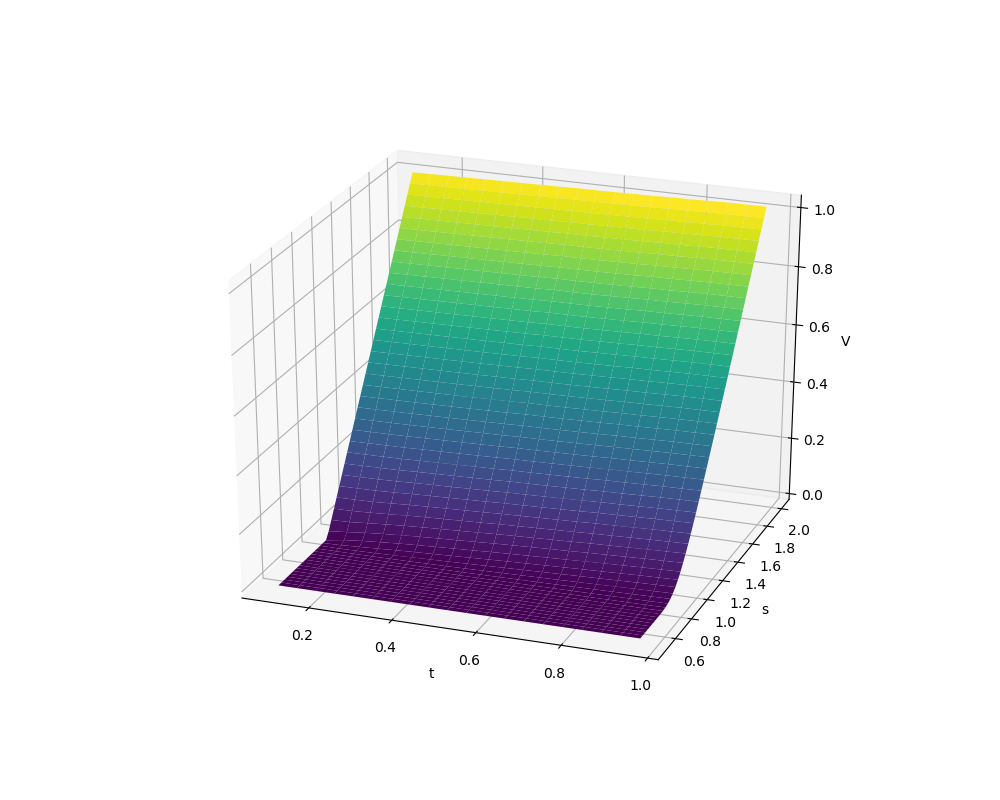

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
%matplotlib nbagg
fig = plt.figure(figsize=(10,8))

#ax = Axes3D(fig) #<-- Note the difference from your original code...
X,T = np.meshgrid(x,tau)
#fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(t, s, V, 50, cmap='jet')
ax.plot_surface(T,X,u_tilda, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('t')
ax.set_ylabel('s')
ax.set_zlabel('V')
plt.show()

## 3/2

In [30]:
def Three_half_Euler(M, N, r, kappa, theta, epsilon, rho, S0, V0):
    
    S = np.zeros((M,N))
    S[0,:] = S0
    V = V0
    dt = 0.9/2499
    
    for i in range(M-1):
        
        Z1 = np.random.normal(size=(N))
        Z2 = np.random.normal(size=(N))
        Zv = Z1 
        Zs = rho*Z1 + np.sqrt(1 - rho**2)*Z2
        
        S[i+1,:] = S[i,:]*np.exp((r-V/2)*dt + np.sqrt(V*dt)*Zs)
        V_delta = V + V*(theta - kappa*V)*dt + epsilon*V**(3/2)*np.sqrt(dt)*Zv
        
        V_delta[np.where(V_delta < 0)] = 0
        V = V_delta
        
    return S
    
    

In [135]:
0.6/0.03

20.0

In [31]:
import scipy
import numpy as np
x = scipy.linspace(0.5,2.,1000) # x = S/K
S0 = 2000
tau = np.linspace(0.1,1,2500)

np.random.seed(0)
S = Three_half_Euler(2500,10000,0.02,2,0.055,20,-0.7,2000,0.03)
#S = GARCH_Milstein(2501,10000,0.02, 2,0.055,0.6,-0.7,2000,0.055)
K = S0/x
u = multioptions_price(S,0.02,tau,K)
u_tilda = u/K

In [32]:
u_tilda.shape

(2500, 1000)

In [6]:
K = S0/x
K,_=np.meshgrid(K,tau)
K.shape

(500, 1000)

In [34]:
ls = []
for i in range(2500):
    if i%5== 0:
        ls.append(i)
idx = np.array(ls)


In [35]:
idx.shape

(500,)

In [33]:
2500/500

5.0

In [36]:
Exact = u_tilda
tau = tau[idx,]
u_tilda = Exact[idx,:]
K = S0/x
K,_=np.meshgrid(K,tau)

In [38]:
K.shape

(500, 1000)

In [31]:
import tensorflow as tf

In [39]:
X,T = np.meshgrid(x,tau)
X = X.flatten()[:,None]
T = T.flatten()[:,None]
u_min = np.maximum((X-np.exp(-0.02*T)),0)
u_tilda = u_tilda.flatten()[:,None]
#for y in np.hstack([u_tilda.flatten()[:,None],u_min]):
#    print(y)

In [40]:
u_tilda[u_tilda<u_min].shape

(231597,)

In [41]:
/500000

0.463194

In [10]:
u_tilda = np.maximum(u_tilda,u_min)
u_tilda = u_tilda.reshape(500,1000)

## for fit + solver

first generate the data field as usual for u_tilda i.e. matrix(tau,x) $\in$ $R^{500}\times R^{1000}$, then do the following.

In [12]:
ls = []
for i in range(499):
    if i%25 == 0:
        ls.append(i)
idx1 = np.array(ls)
idx1.shape

(20,)

In [13]:
ls = []
for i in range(998):
    if i%20 == 0:
        ls.append(i)
idx2 = np.array(ls)
idx2.shape

(50,)

In [14]:
# domain

# first, remove the initial and boundary
u_tilda_dom = u_tilda[:,1::] # retain all except b1
u_tilda_dom = u_tilda_dom[:,0:-1] # retain all except b2
u_tilda_dom = u_tilda_dom[1::,:] # retain all except ini

K_dom = K[:,1::]
K_dom = K_dom[:,0:-1]
K_dom = K_dom[1::,:] 

x_dom = x[1:-1]
tau_dom = tau[1::]

# next, filter 1000 data-points out of this field
u_tilda_dom = u_tilda_dom[idx1,:]
u_tilda_dom = u_tilda_dom[:,idx2]

K_dom = K_dom[idx1,:]
K_dom = K_dom[:,idx2]

x_dom = x_dom[idx2]
tau_dom = tau_dom[idx1]

In [15]:
# filter initial
x_ini = x
tau_ini = np.repeat(min(tau),x.shape[0])
u_tilda_ini = u_tilda[0:1,:]
K_ini = K[0:1,:]

In [16]:
# filter boundary
x_b1 = np.repeat(min(x),tau.shape[0])
tau_b1 = tau
u_tilda_b1 = u_tilda[:,0:1]
K_b1 = K[:,0:1]

x_b2 = np.repeat(max(x),tau.shape[0])
tau_b2 = tau
u_tilda_b2 = u_tilda[:,999:1000]
K_b2 = K[:,999:1000]

In [28]:
print(tau_b1.shape)
print(x_b1.shape)
print(u_tilda_b1.shape)
print(K_b1.shape)

(500,)
(500,)
(500, 1)
(500, 1)


In [18]:
data = {'t': tau_dom, 'x':x_dom, 'usol':u_tilda_dom, 'K':K_dom}
import pickle
filename = 'Three_half_Simulation_data_1'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

In [21]:
data = {'t': tau_ini, 'x':x_ini, 'usol':u_tilda_ini, 'K':K_ini}
import pickle
filename = 'Three_half_Simulation_data_1_ini'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

<IPython.core.display.Javascript object>


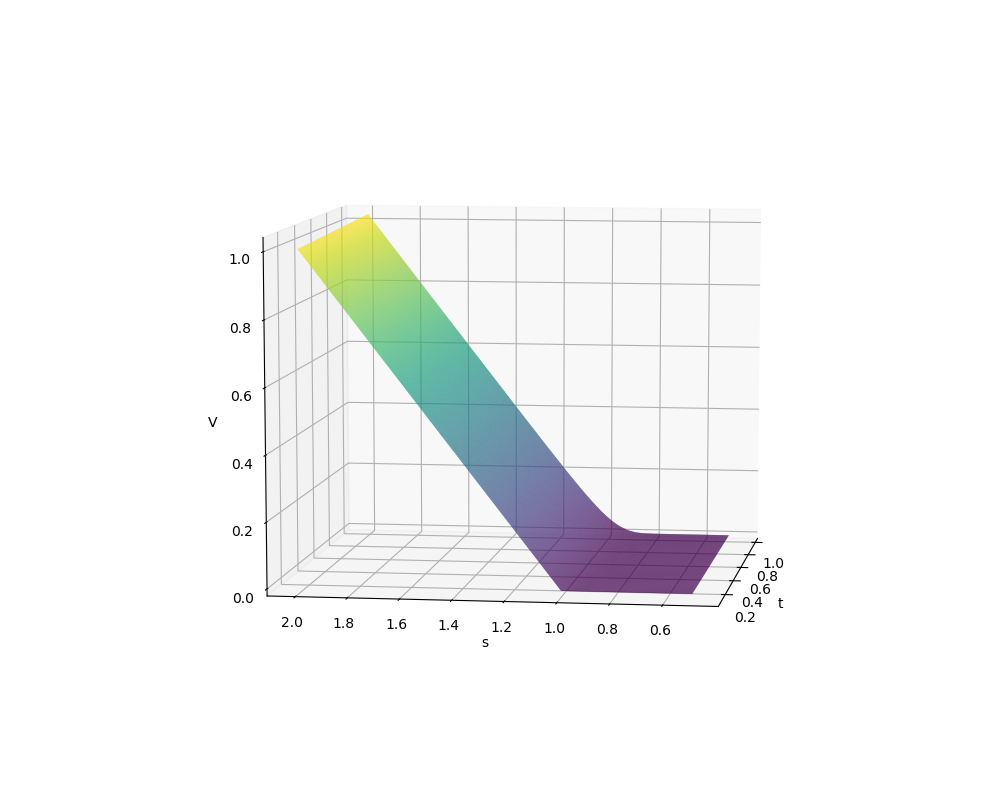

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
%matplotlib nbagg
fig = plt.figure(figsize=(10,8))

#ax = Axes3D(fig) #<-- Note the difference from your original code...
X,T = np.meshgrid(x,tau)
#fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(t, s, V, 50, cmap='jet')
ax.plot_surface(T,X,u_tilda, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('t')
ax.set_ylabel('s')
ax.set_zlabel('V')
plt.show()

# CEV

In [1]:
def CEV_Euler(M, N, r, S0, sigma, gamma):
    
    S = np.zeros((M,N))
    S[0,:] = S0
    dt = 0.9/499
    
    for i in range(M-1):
        
        Z = np.random.normal(size=(N))
        S[i+1,:] = S[i,:] + r*S[i,:]*dt + sigma*(S[i,:])**gamma*np.sqrt(dt)*Z
        
    return S
    
    

In [29]:
1.06*(2000**(-0.03))

0.8438688683909281

In [146]:
0.4*2000**0.2

1.8292202077093056

In [2]:
import scipy
import numpy as np
x = scipy.linspace(0.5,2.,1000) # x = S/K
S0 = 2000
tau = np.linspace(0.1,1,500)

np.random.seed(0)
S = CEV_Euler(500,10000,0.02,2000,1.83,0.8)
#S = GARCH_Milstein(2501,10000,0.02, 2,0.055,0.6,-0.7,2000,0.055)
K = S0/x
u = multioptions_price(S,0.02,tau,K)
u_tilda = u/K

NameError: name 'multioptions_price' is not defined

In [149]:
ls = []
for i in range(2501):
    if i%126 == 0:
        ls.append(i)
idx = np.array(ls)


In [150]:
idx.shape

(20,)

In [151]:
Exact = u_tilda
tau = tau[idx,]
u_tilda = Exact[idx,:]
K = S0/x
K,_=np.meshgrid(K,tau)

In [39]:
K = S0/x
K,_=np.meshgrid(K,tau)
X,T = np.meshgrid(x,tau)
X = X.flatten()[:,None]
T = T.flatten()[:,None]
u_min = np.maximum((X-np.exp(-0.02*T)),0)
u_tilda = u_tilda.flatten()[:,None]
#for y in np.hstack([u_tilda.flatten()[:,None],u_min]):
#    print(y)

In [10]:
u_tilda[u_tilda<u_min].shape

ValueError: operands could not be broadcast together with shapes (500,1000) (500000,1) 

In [40]:
u_tilda = np.maximum(u_tilda,u_min)
u_tilda = u_tilda.reshape(500,1000)

## Fit & Solve PDE

In [41]:
ls = []
for i in range(499):
    if i%25 == 0:
        ls.append(i)
idx1 = np.array(ls)
idx1.shape

(20,)

In [42]:
ls = []
for i in range(998):
    if i%20 == 0:
        ls.append(i)
idx2 = np.array(ls)
idx2.shape

(50,)

In [43]:
# domain

# first, remove the initial and boundary
u_tilda_dom = u_tilda[:,1::] # retain all except b1
u_tilda_dom = u_tilda_dom[:,0:-1] # retain all except b2
u_tilda_dom = u_tilda_dom[1::,:] # retain all except ini

K_dom = K[:,1::]
K_dom = K_dom[:,0:-1]
K_dom = K_dom[1::,:] 

x_dom = x[1:-1]
tau_dom = tau[1::]

# next, filter 1000 data-points out of this field
u_tilda_dom = u_tilda_dom[idx1,:]
u_tilda_dom = u_tilda_dom[:,idx2]

K_dom = K_dom[idx1,:]
K_dom = K_dom[:,idx2]

x_dom = x_dom[idx2]
tau_dom = tau_dom[idx1]

In [44]:
# filter initial
x_ini = x
tau_ini = np.repeat(min(tau),x.shape[0])
u_tilda_ini = u_tilda[0:1,:]
K_ini = K[0:1,:]

In [45]:
# filter boundary
x_b1 = np.repeat(min(x),tau.shape[0])
tau_b1 = tau
u_tilda_b1 = u_tilda[:,0:1]
K_b1 = K[:,0:1]

x_b2 = np.repeat(max(x),tau.shape[0])
tau_b2 = tau
u_tilda_b2 = u_tilda[:,999:1000]
K_b2 = K[:,999:1000]

In [50]:
data = {'t': tau_b2, 'x':x_b2, 'usol':u_tilda_b2, 'K':K_b2}
import pickle
filename = 'CEV_Simulation_data_1_b2'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

In [47]:
data = {'t': tau_dom, 'x':x_dom, 'usol':u_tilda_dom, 'K':K_dom}
import pickle
filename = 'CEV_Simulation_data_1'
outfile = open(filename,'wb')
pickle.dump(data,outfile)
outfile.close()

<IPython.core.display.Javascript object>


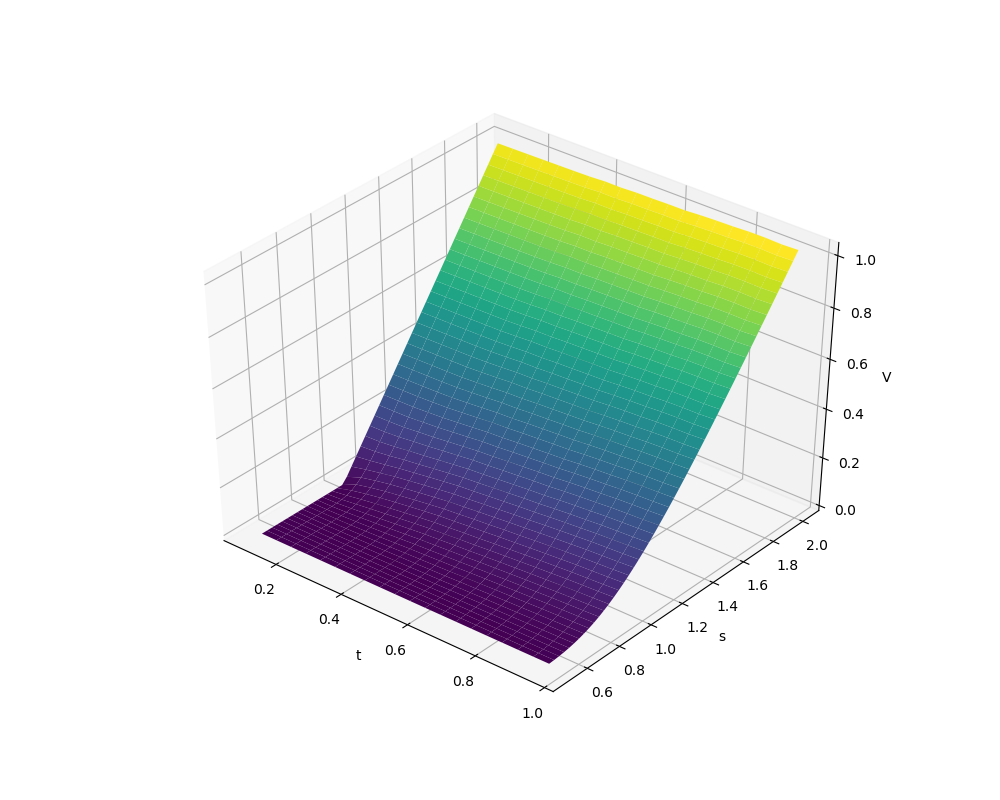

In [156]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
%matplotlib nbagg
fig = plt.figure(figsize=(10,8))

#ax = Axes3D(fig) #<-- Note the difference from your original code...
X,T = np.meshgrid(x,tau)
#fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(t, s, V, 50, cmap='jet')
ax.plot_surface(T,X,u_tilda, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('t')
ax.set_ylabel('s')
ax.set_zlabel('V')
plt.show()

In [70]:
sigma0 = 0.4
s0 = 2000
r = 0.02
beta = 1.6

for i in np.hstack([X,T,K]):
    delta = sigma0*s0**(1-(beta/2))
    k = (2*r)/(delta**2*(2-beta)*(np.exp(r*(2-beta)*i[1])-1))
    x = k*s0**(2-beta)*np.exp(r*(2-beta)*i[1])
    y = k*i[2]**(2-beta)
    c = i[0]*np.random.noncentral_chisquare(2+2/(2-beta),2*x) - np.exp(-r*i[1])*(1-np.random.noncentral_chisquare(2/(2-beta),2*y))
    print(c/i[2])

0.71223110367591
0.7696714415169836
0.7939825473873858
0.8112090147555707
0.87009879545202
0.9316472249077287
1.001932146829763
1.0615404198967642
1.061058594655719
1.1567287513465498
1.2011268026791868
1.2502075256071545
1.3379918774324011
1.3849281557933897
1.3729335157070357
1.414590571249213
1.4897482705967864
1.617961054815901
1.684000577513612
1.772600509089458
1.7305056486213801
1.863986295047122
1.9176866472201937
2.0089426526768435
2.0995413323606846
2.168743881406456
2.1887496174443988
2.151419604121089
2.3279765052081602
2.50970708234365
2.448889224808529
2.7229495219988933
2.5843728688276086
2.676656925153792
2.870537689053037
3.2110924646389445
3.0731954205041
3.251508292956109
3.309392695480398
3.2862076511572837
3.575141789038369
3.454192066879337
3.6297887390517727
3.8591540135281766
3.913587138299661
3.7804197876632943
3.8369361259127874
4.040455165200932
4.13672669838296
4.187247405871959
0.5068031147720368
0.5217435384034314
0.5347520044080611
0.6079505780258175
0.62